## Get Biomechanics Data Online from Driveline

In [1]:
# Import required libraries for web scraping, file handling, and data processing
import requests  # For making HTTP requests to fetch web pages and download files
from bs4 import BeautifulSoup  # For parsing HTML content to extract .zip file links
import zipfile  # For handling ZIP file extraction
import os  # For interacting with the operating system (e.g., file paths)
import pandas as pd  # For reading .tsv files into DataFrames
from io import BytesIO  # For handling in-memory binary data (ZIP files)
from pathlib import Path  # For modern, cross-platform file path handling
# Import required libraries for downloading and processing C3D files
import ezc3d  # For reading and parsing C3D files
from functools import reduce
from IPython import get_ipython
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

meta_data = pd.read_csv('https://raw.githubusercontent.com/drivelineresearch/openbiomechanics/refs/heads/main/baseball_pitching/data/metadata.csv')
poi_metrics = pd.read_csv('https://raw.githubusercontent.com/drivelineresearch/openbiomechanics/refs/heads/main/baseball_pitching/data/poi/poi_metrics.csv')

In [2]:
meta_data.head(10)

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d
5,653,1170,1170_1,82.1016,1.9304,20.52,college,80.9,000653_001170_76_181_001_FF_809.c3d,000653_001170_model.c3d
6,653,1170,1170_2,82.1016,1.9304,20.52,college,82.6,000653_001170_76_181_002_FF_826.c3d,000653_001170_model.c3d
7,738,1250,1250_1,78.4728,1.7526,21.49,college,88.1,000738_001250_69_173_002_FF_881.c3d,000738_001250_model.c3d
8,738,1250,1250_3,78.4728,1.7526,21.49,college,88.6,000738_001250_69_173_010_FF_886.c3d,000738_001250_model.c3d
9,789,1313,1313_1,84.3696,1.8288,19.02,college,85.8,000789_001313_72_186_006_FF_858.c3d,000789_001313_model.c3d


In [3]:
poi_metrics.head(10)

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.4060,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.5650,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.5580,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.6130,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,158.8107,121.7674,30.4130,31.7880,47.1102,95.6806,5.7281,-176.7390,318.5102,333.5518,-3.6689,-4.9416,-9.6014,9.5675,-1.9345,22.1156,2.9110,-31.6853,881.1570,46.9422,81.8611,-33.7316,28.7365,83.8787,31.2288,29.1355,129.9182,132.9853,129.8250,45.1741,21.1152,142.5116,26.2749,0.2008,0.8133,7.9460,49.1484,0.0250,49.0236,307.9884,7.2968,54.3387,301.6148,7.7581,24.0842,133.6156,4.6376,106.6119,136.0782,69.9222,26.2777,56.0486,146.2910,62.6569,51.9809,28.8661,25.1778,176.2563,361.8390,681.3699,114.3219,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,155.2244,124.6367,27.9551,27.9139,46.6610,94.4698,1

In [4]:
driveline = pd.merge(meta_data, poi_metrics, on='session_pitch', how='inner')
driveline.head(3)

,user,session_x,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph_x,filename_new,modelname_new,session_y,p_throws,pitch_type,pitch_speed_mph_y,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.4060,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.5650,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.5580,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.6130,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,158.8107,121.7674,30.4130,31.7880,47.1102,95.6806,5.7281,-176.7390,318.5102,333.5518,-3.6689,-4.9416,-9.6014,9.5675,-1.9345,22.1156,2.9110,-31.6853,881.1570,46.9422,81.8611,-33.7316,28.7365,83.8787,31.2288,29.1355,129.9182,132.9853,129.8250,45.1741,21.1152,142.5116,26.2749,0.2008,

In [5]:
print(driveline.isna().sum())
print(driveline.dtypes)
print(len(driveline))

user                                         0
session_x                                    0
session_pitch                                0
session_mass_kg                              0
session_height_m                             0
age_yrs                                      0
playing_level                                0
pitch_speed_mph_x                            0
filename_new                                 0
modelname_new                                0
session_y                                    0
p_throws                                     0
pitch_type                                   0
pitch_speed_mph_y                            0
max_shoulder_internal_rotational_velo        0
max_elbow_extension_velo                     0
max_torso_rotational_velo                    0
max_rotation_hip_shoulder_separation         0
max_elbow_flexion                            0
max_shoulder_external_rotation               0
elbow_flexion_fp                             0
elbow_pronati

In [6]:
driveline['pitch_type'].unique()

array(['FF'], dtype=object)

In [7]:
driveline = driveline.dropna()
driveline = driveline.drop(['pitch_speed_mph_y', 'session_y', 'pitch_type'], axis=1)

In [8]:
driveline.head(2)

,user,session_x,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph_x,filename_new,modelname_new,p_throws,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,750,1031,1031_2,110.6784,1.9304,21.4,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d,R,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.406,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.565,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,750,1031,1031_3,110.6784,1.9304,21.4,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d,R,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.558,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.613,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636


In [9]:
float_cols = driveline.select_dtypes(include=['float64', 'float32']).columns.tolist()
float_df = driveline[float_cols].copy()
float_df.head(2)

,session_mass_kg,session_height_m,age_yrs,pitch_speed_mph_x,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,elbow_flexion_fp,elbow_pronation_fp,rotation_hip_shoulder_separation_fp,shoulder_horizontal_abduction_fp,shoulder_abduction_fp,shoulder_external_rotation_fp,lead_knee_extension_angular_velo_fp,lead_knee_extension_angular_velo_br,lead_knee_extension_angular_velo_max,torso_anterior_tilt_fp,torso_lateral_tilt_fp,torso_rotation_fp,pelvis_anterior_tilt_fp,pelvis_lateral_tilt_fp,pelvis_rotation_fp,max_cog_velo_x,torso_rotation_min,max_pelvis_rotational_velo,glove_shoulder_horizontal_abduction_fp,glove_shoulder_abduction_fp,glove_shoulder_external_rotation_fp,glove_shoulder_abduction_mer,elbow_flexion_mer,torso_anterior_tilt_mer,torso_lateral_tilt_mer,torso_rotation_mer,elbow_varus_moment,shoulder_internal_rotation_moment,torso_anterior_tilt_br,torso_lateral_tilt_br,torso_rotation_br,lead_knee_extension_from_fp_to_br,cog_velo_pkh,stride_length,stride_angle,arm_slot,timing_peak_torso_to_peak_pelvis_rot_velo,max_shoulder_horizontal_abduction,shoulder_transfer_fp_br,shoulder_generation_fp_br,shoulder_absorption_fp_br,elbow_transfer_fp_br,elbow_generation_fp_br,elbow_absorption_fp_br,lead_hip_transfer_fp_br,lead_hip_generation_fp_br,lead_hip_absorption_fp_br,lead_knee_transfer_fp_br,lead_knee_generation_fp_br,lead_knee_absorption_fp_br,rear_hip_transfer_pkh_fp,rear_hip_generation_pkh_fp,rear_hip_absorption_pkh_fp,rear_knee_transfer_pkh_fp,rear_knee_generation_pkh_fp,rear_knee_absorption_pkh_fp,pelvis_lumbar_transfer_fp_br,thorax_distal_transfer_fp_br,rear_grf_x_max,rear_grf_y_max,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,110.6784,1.9304,21.4,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,86.3476,13.8688,31.5769,53.7302,88.9089,12.406,160.4524,449.4070,452.7888,-2.6113,-7.0313,0.3425,8.2744,-1.7844,31.7105,3.3113,-21.1062,609.9531,38.3919,85.9397,-46.6380,45.4970,93.9717,16.9991,22.1885,99.4708,141.1720,135.2726,34.1093,16.9053,111.1709,10.1399,0.4643,0.8374,5.3785,39.7377,0.0223,53.8175,471.6631,72.5180,8.1687,481.4378,7.0827,88.0793,48.2958,11.5949,119.5385,70.8131,74.7670,32.1040,130.8791,173.1504,37.6984,33.8403,111.565,88.4883,157.7995,479.8318,1019.3193,103.0399,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,110.6784,1.9304,21.4,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,88.6095,12.6106,31.2877,55.7340,87.0463,18.558,300.1992,490.8747,513.3286,-4.2198,-8.5668,3.1764,5.0692,-1.2554,33.9670,3.2385,-23.6528,639.6493,42.5471,85.2882,-47.7522,45.2598,93.6559,14.1951,23.5327,98.4928,144.5483,138.5700,33.9700,18.7871,112.8332,14.8421,0.4367,0.8316,1.1214,42.9766,0.0139,55.9667,468.4177,66.5717,9.3845,474.0084,6.4195,81.1477,65.9816,12.0415,110.9249,89.3801,67.1017,23.9261,125.1987,180.7929,40.8556,28.0193,109.613,104.7412,170.3120,477.8022,989.5197,109.2064,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636


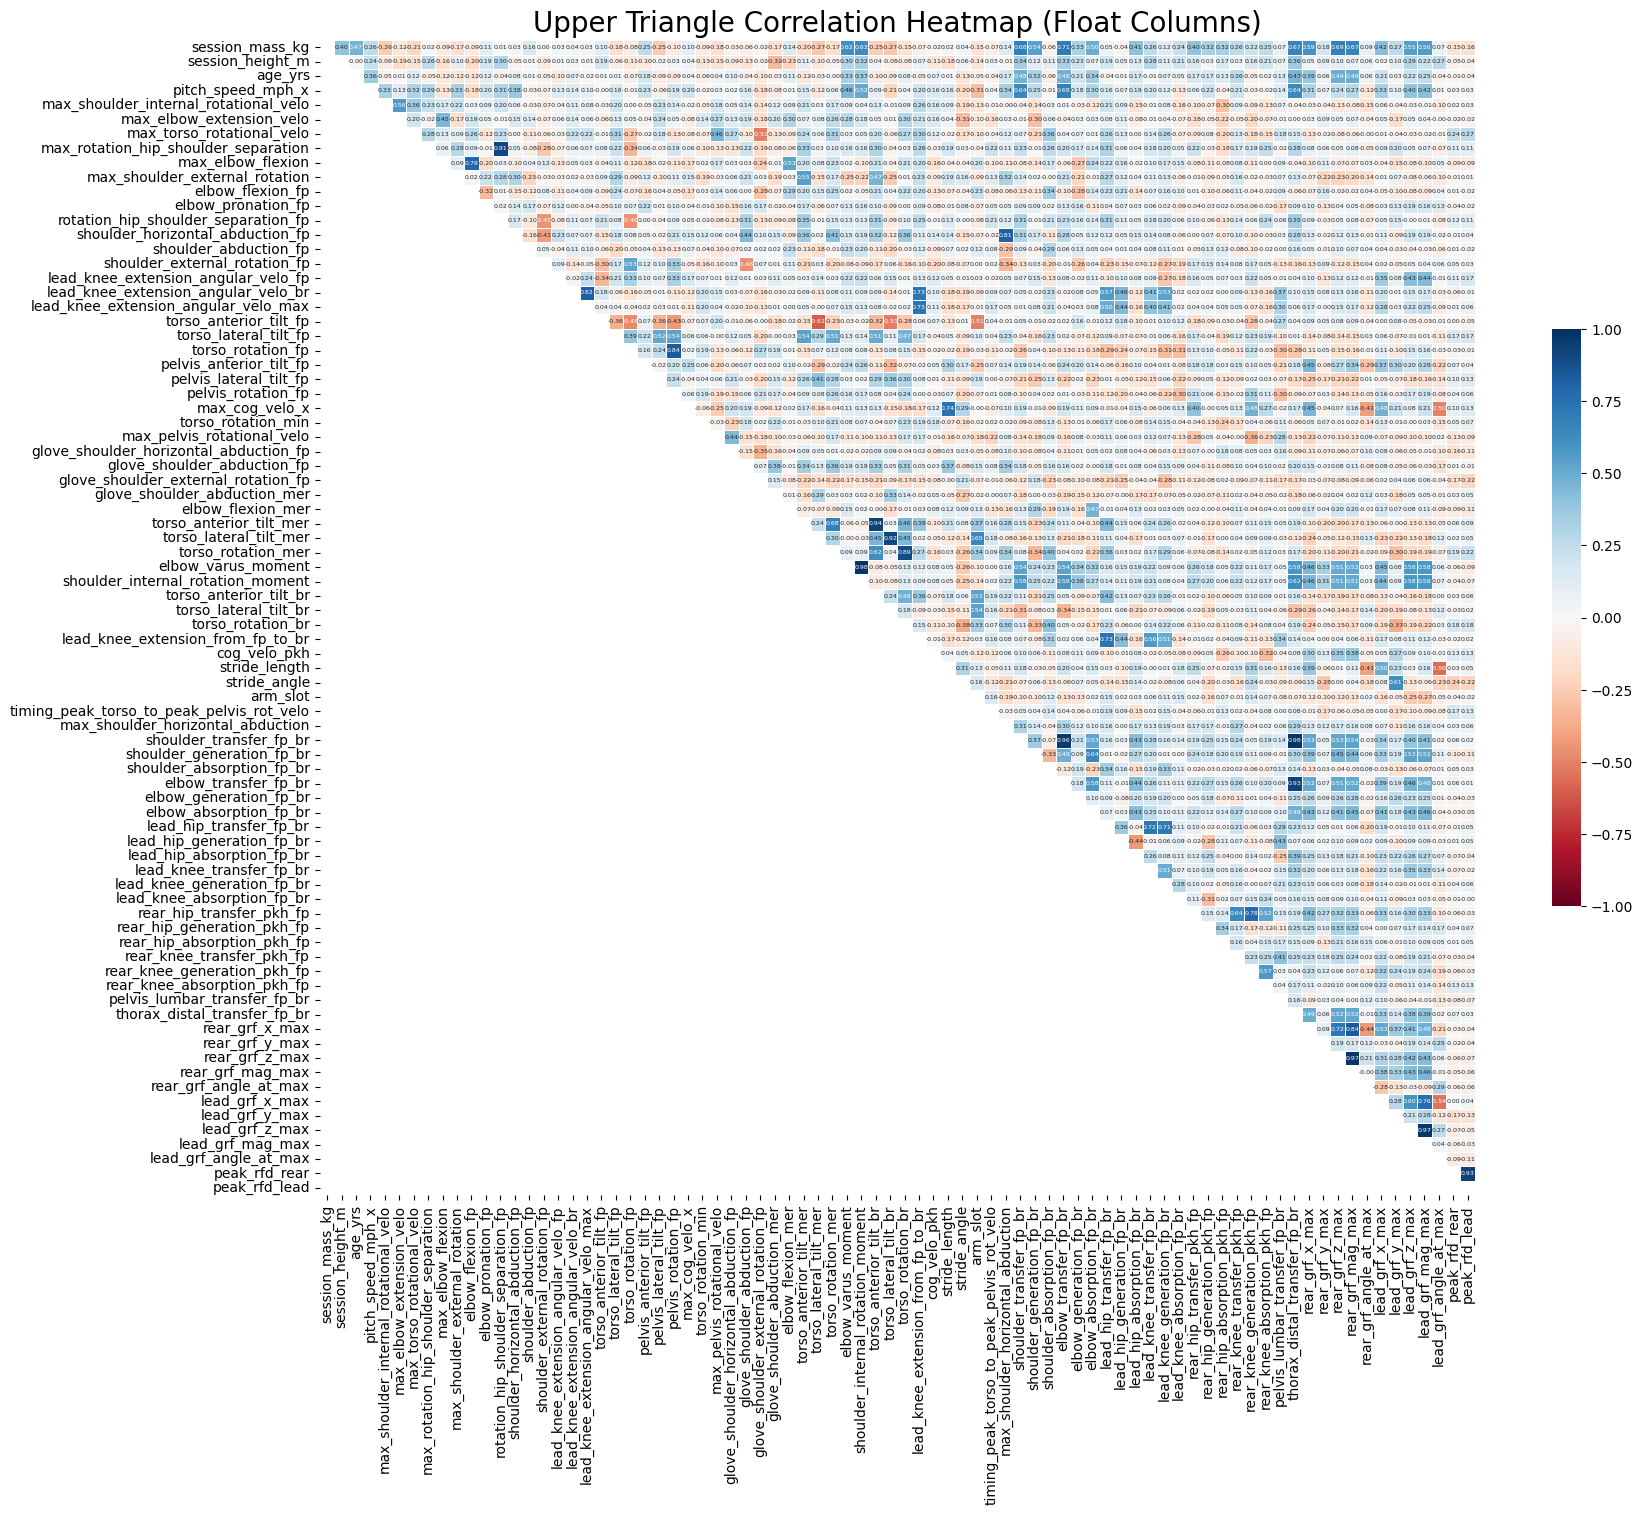

In [14]:
# Compute correlation matrix
corr = float_df.corr()

# Zero out diagonal (optional)
np.fill_diagonal(corr.values, 0)

# Keep only upper triangle
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Plot heatmap with CORRECT colormap
plt.figure(figsize=(20, 15))
sns.heatmap(
    upper,
    cmap='RdBu',           # Diverging colormap: red=positive, blue=negative
    vmin=-1, vmax=1,
    center=0,
    annot=True,
    fmt='.2f',
    annot_kws={'fontsize': 4.5, 'fontweight': 'normal'},  # SMALL FONT
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.title("Upper Triangle Correlation Heatmap (Float Columns)", fontsize=20)
plt.show()

In [19]:
# All correlations of pitch_speed_mph_x with every other column
corr_with_speed = float_df.corrwith(float_df['pitch_speed_mph_x']).sort_values(ascending=False)
print(corr_with_speed.round(3))

pitch_speed_mph_x                            1.000
elbow_transfer_fp_br                         0.682
shoulder_transfer_fp_br                      0.643
thorax_distal_transfer_fp_br                 0.636
shoulder_internal_rotation_moment            0.517
elbow_varus_moment                           0.460
lead_grf_mag_max                             0.420
lead_grf_z_max                               0.401
shoulder_horizontal_abduction_fp             0.378
age_yrs                                      0.357
max_shoulder_horizontal_abduction            0.339
lead_grf_x_max                               0.332
max_shoulder_external_rotation               0.332
max_shoulder_internal_rotational_velo        0.325
max_torso_rotational_velo                    0.320
rotation_hip_shoulder_separation_fp          0.311
rear_grf_x_max                               0.310
elbow_absorption_fp_br                       0.304
max_rotation_hip_shoulder_separation         0.291
rear_grf_mag_max               

In [30]:
# Step 1: Compute correlations
corr_with_speed = float_df.corrwith(float_df['pitch_speed_mph_x'])

# Step 2: Drop self-correlation
corr_with_speed = corr_with_speed.drop('pitch_speed_mph_x', errors='ignore')

# Step 3: Convert Series → DataFrame with clear column names
corr_df = corr_with_speed.to_frame(name='correlation_with_pitch_speed_mph')

# Step 5: Reset index to make variable names a real column
corr_df = corr_df.reset_index()
corr_df.columns = ['variable', 'correlation']

# Step 6: Display cleanly
print(corr_df.round(6).to_string(index=False))

                                 variable  correlation
                          session_mass_kg     0.256265
                         session_height_m     0.242071
                                  age_yrs     0.357022
    max_shoulder_internal_rotational_velo     0.325236
                 max_elbow_extension_velo     0.125327
                max_torso_rotational_velo     0.320079
     max_rotation_hip_shoulder_separation     0.291260
                        max_elbow_flexion    -0.125638
           max_shoulder_external_rotation     0.331665
                         elbow_flexion_fp    -0.177697
                       elbow_pronation_fp     0.199400
      rotation_hip_shoulder_separation_fp     0.310999
         shoulder_horizontal_abduction_fp     0.378294
                    shoulder_abduction_fp    -0.034866
            shoulder_external_rotation_fp    -0.069505
      lead_knee_extension_angular_velo_fp     0.132651
      lead_knee_extension_angular_velo_br     0.139491
     lead_

In [32]:
corr_df = corr_df.sort_values('correlation', ascending=False)
corr_df

,variable,correlation
50,elbow_transfer_fp_br,0.682210
47,shoulder_transfer_fp_br,0.642701
66,thorax_distal_transfer_fp_br,0.636098
36,shoulder_internal_rotation_moment,0.516925
35,elbow_varus_moment,0.460446
75,lead_grf_mag_max,0.420398
74,lead_grf_z_max,0.400618
12,shoulder_horizontal_abduction_fp,0.378294
2,age_yrs,0.357022
46,max_shoulder_horizontal_abduction,0.338802


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8')])

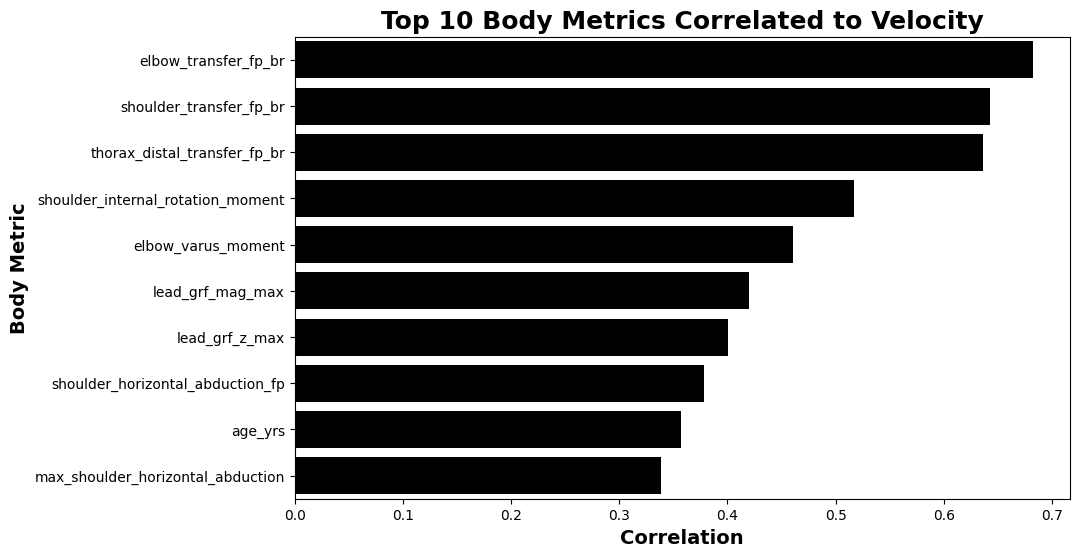

In [37]:
top_10 = corr_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10,
    x='correlation',
    y='variable',  # ← Use the column, NOT .index
    color='black'
)

plt.title('Top 10 Body Metrics Correlated to Velocity', fontsize=18, fontweight='bold')
plt.xlabel('Correlation', fontsize=14, fontweight='bold')
plt.ylabel('Body Metric', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)


(array([-0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ]),
 [Text(-0.35000000000000003, 0, '−0.35'),
  Text(-0.30000000000000004, 0, '−0.30'),
  Text(-0.25, 0, '−0.25'),
  Text(-0.2, 0, '−0.20'),
  Text(-0.15000000000000002, 0, '−0.15'),
  Text(-0.10000000000000003, 0, '−0.10'),
  Text(-0.04999999999999999, 0, '−0.05'),
  Text(0.0, 0, '0.00')])

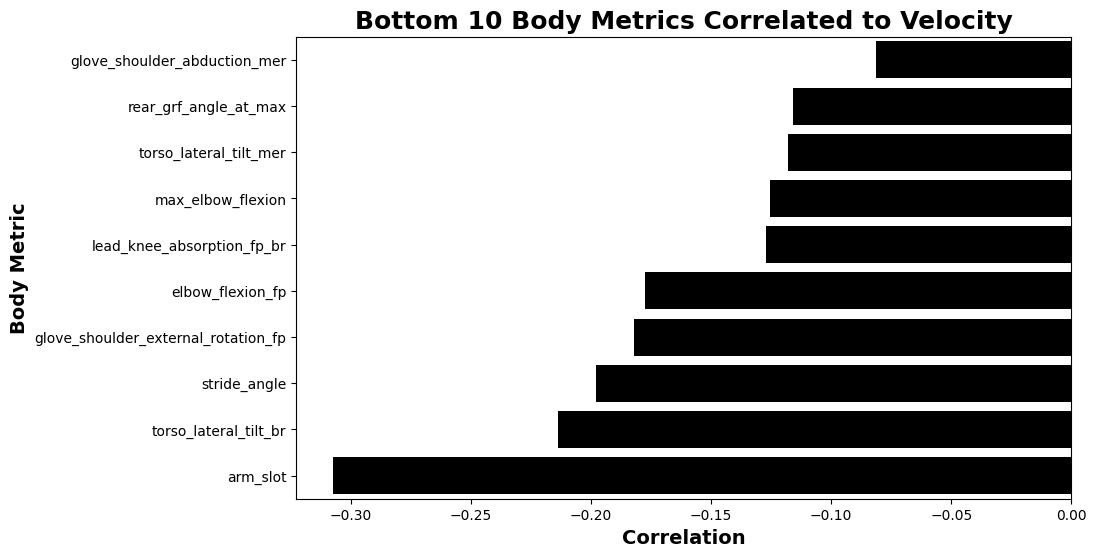

In [38]:
bottom_10 = corr_df.tail(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=bottom_10,
    x='correlation',
    y='variable',  # ← Use the column, NOT .index
    color='black'
)

plt.title('Bottom 10 Body Metrics Correlated to Velocity', fontsize=18, fontweight='bold')
plt.xlabel('Correlation', fontsize=14, fontweight='bold')
plt.ylabel('Body Metric', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)


In [ ]:
# Step 1: Define the directory to search for .csv files
# Using the user's Downloads folder as the default path (modify if needed)
downloads_dir = Path(os.path.expanduser(r'C:\Users\cboat\OneDrive\Documents\Driveline Data'))  # Resolves to ~/Downloads on Windows/macOS/Linux
# Alternative: Specify a custom path, e.g., downloads_dir = Path('path/to/extracted/folder')
print(f"Searching for .csv files in: {downloads_dir}")

# Step 2: Initialize a dictionary to store loaded datasets
loaded_datasets = {}  # Dict to hold DataFrames: {csv_filename_without_extension: df}

# Step 3: Find and load all .csv files recursively
csv_files_found = False  # Flag to track if any .csv files are found
for csv_path in downloads_dir.rglob('*.csv'):  # Recursively find all .csv files
    csv_files_found = True
    dataset_name = csv_path.stem  # Get filename without .csv (e.g., 'pitch1' from 'pitch1.csv')
    print(f"Processing {csv_path}...")

    try:
        # Try loading as comma-separated CSV first
        loaded_datasets[dataset_name] = pd.read_csv(csv_path, sep=',')
        print(f"Loaded dataset '{dataset_name}' with shape {loaded_datasets[dataset_name].shape}")
    except pd.errors.ParserError as e:
        print(f"Error parsing {csv_path} as comma-separated: {e}. Trying tab-separated...")
        try:
            # Fallback: Try tab-separated (in case it's a .tsv misnamed as .csv)
            loaded_datasets[dataset_name] = pd.read_csv(csv_path, sep='\t')
            print(f"Loaded dataset '{dataset_name}' (tab-separated) with shape {loaded_datasets[dataset_name].shape}")
        except pd.errors.ParserError as e:
            print(f"Error parsing {csv_path} as tab-separated: {e}. Skipping.")
            continue
    except Exception as e:
        print(f"Unexpected error loading {csv_path}: {e}. Skipping.")
        continue

# Step 4: Report results
if not csv_files_found:
    print(f"No .csv files found in {downloads_dir} or its subfolders.")
else:
    print(f"\nLoaded {len(loaded_datasets)} datasets into 'loaded_datasets' dict:")
    for dataset_name, df in loaded_datasets.items():
        print(f" - '{dataset_name}': {df.shape}")

# After reporting
if 'df' in globals():
    del df
print("Cleaned up temporary 'df' variable.")
# Access datasets like: loaded_datasets['pitch1']

In [ ]:
# --------------------------------------------------------------
# 1. Unpack the dictionary into separate variables
# --------------------------------------------------------------
if not loaded_datasets:
    raise RuntimeError("loaded_datasets is empty – run the loading code first!")

for name, df in loaded_datasets.items():
    # Create a variable in the *global* namespace
    globals()[name] = df
    print(f"Created variable → {name}  (shape: {df.shape})")

# --------------------------------------------------------------
# 2. Quick verification – list the 6 objects
# --------------------------------------------------------------
print("\n--- All 6 datasets are now independent variables ---")
for name in loaded_datasets.keys():
    var = globals()[name]
    print(f"{name}: {var.shape[0]:,} rows × {var.shape[1]:,} columns")

# After reporting
if 'var' in globals():
    del var
print("Cleaned up temporary 'var' variable.")

In [ ]:
energy_flow.head(3)

In [ ]:
forces_moments.head(3)

In [ ]:
force_plate.head(3)

In [ ]:
dfs = [energy_flow, forces_moments, force_plate, joint_angles, joint_velos, landmarks, meta_data, poi_metrics]

# Remove columns with all NaN values from each DataFrame in-place
for i, df in enumerate(dfs):
    # Identify columns where ALL values are NaN
    all_nan_cols = df.columns[df.isna().all()].tolist()
    
    if all_nan_cols:
        print(f"Dropping {len(all_nan_cols)} all-NaN column(s) from DataFrame {i}: {all_nan_cols}")
        dfs[i] = df.drop(columns=all_nan_cols)
    else:
        print(f"No all-NaN columns found in DataFrame {i}.")

In [ ]:
df_names = ['energy_flow', 'forces_moments', 'force_plate', 'joint_angles', 
            'joint_velos', 'landmarks', 'meta_data', 'poi_metrics']

for name, df in zip(df_names, dfs):
    col_count = df.shape[1]  # Number of columns
    print(f"{name:<15}: {col_count:>3} columns")

# After reporting
if 'df' in globals():
    del df
print("Cleaned up temporary 'df' variable.")

In [ ]:
# --------------------------------------------------------------
# Find all pandas DataFrames in the current namespace and show dtypes
# --------------------------------------------------------------
import pandas as pd
from IPython import get_ipython

# Get the user namespace (all variables in your kernel)
user_ns = get_ipython().user_ns

# Filter for pandas DataFrames
dataframes = {
    name: obj for name, obj in user_ns.items()
    if isinstance(obj, pd.DataFrame) and not name.startswith('_')
}

# Sort by name for clean output
dataframes = dict(sorted(dataframes.items()))

print(f"Found {len(dataframes)} DataFrame(s) in the kernel:\n")
print("="*80)

for name, df in dataframes.items():
    print(f"{name}")
    print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
    print(f"   Memory: ~{df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
    print(f"   Columns (first 10): {df.columns[:10].tolist()}")
    print("\n   dtypes:")
    print(df.dtypes.to_string())
    print("-" * 80)

In [ ]:
# --------------------------------------------------------------
# Find columns that appear in MULTIPLE datasets
# --------------------------------------------------------------

# Step 1: Get all DataFrames from the current kernel
user_ns = get_ipython().user_ns
dataframes = {
    name: obj for name, obj in user_ns.items()
    if isinstance(obj, pd.DataFrame) and not name.startswith('_')
}

if not dataframes:
    print("No DataFrames found in the kernel.")
else:
    print(f"Found {len(dataframes)} DataFrame(s): {list(dataframes.keys())}\n")
    print("="*90)

# Step 2: Build a map: column_name → list of dataset names that have it
column_to_datasets = defaultdict(list)

for name, df in dataframes.items():
    for col in df.columns:
        column_to_datasets[col].append(name)

# Step 3: Filter to columns that appear in 2+ datasets
shared_columns = {
    col: datasets for col, datasets in column_to_datasets.items()
    if len(datasets) > 1
}

# Step 4: Sort by how many datasets share the column (most common first)
shared_columns = dict(sorted(
    shared_columns.items(),
    key=lambda x: len(x[1]),
    reverse=True
))

# Step 5: Print results
if not shared_columns:
    print("No shared columns found between any datasets.")
else:
    print(f"Found {len(shared_columns)} column(s) shared across multiple datasets:\n")
    for col, datasets in shared_columns.items():
        count = len(datasets)
        print(f"{col}")
        print(f"   → Appears in {count} dataset(s): {', '.join(datasets)}")
        print(f"   → dtypes: " + ", ".join([
            f"{name}: {dataframes[name][col].dtype}" for name in datasets
        ]))
        print("-" * 90)

del df

In [ ]:
from functools import reduce
import pandas as pd

# Step 1: List of time-series datasets
time_series_names = ['energy_flow', 'forces_moments', 'force_plate',
                     'joint_angles', 'joint_velos', 'landmarks']

# Step 2: Get unique session_pitch values
all_session_pitches = set()
for name in time_series_names:
    df = globals()[name]
    if 'session_pitch' in df.columns:
        all_session_pitches.update(df['session_pitch'].unique())

print(f"Found {len(all_session_pitches)} unique pitches: {sorted(all_session_pitches)[:5]}...")

# Step 3: Merge per pitch
all_pitch_data = {}

for pitch in all_session_pitches:
    print(f"\nProcessing pitch: {pitch}")
    
    # Extract data for this pitch only
    pitch_dfs = []
    for name in time_series_names:
        df = globals()[name]
        if 'session_pitch' in df.columns:
            pitch_df = df[df['session_pitch'] == pitch].copy()
            if not pitch_df.empty:
                pitch_dfs.append(pitch_df)
    
    if len(pitch_dfs) < 2:
        print(f"  Only {len(pitch_dfs)} dataset(s) — skipping merge")
        continue
    
    # Merge on 'time' (safe now — same pitch!)
    try:
        merged = reduce(
            lambda l, r: pd.merge(l, r, on='time', how='inner', suffixes=('', '_dup')),
            pitch_dfs
        )
        # Clean up duplicate columns
        dup_cols = [col for col in merged.columns if '_dup' in col]
        merged = merged.drop(columns=dup_cols)
        
        all_pitch_data[pitch] = merged
        print(f"  Merged {len(pitch_dfs)} datasets → {merged.shape}")
        
    except Exception as e:
        print(f"  Error merging {pitch}: {e}")

print(f"\nDone! Merged {len(all_pitch_data)} pitches.")

In [ ]:
# Step 4: Merge with meta_data and poi_metrics
final_dfs = []
for pitch, df in all_pitch_data.items():
    # Add session_pitch
    df['session_pitch'] = pitch
    # Merge with summary
    summary = pd.merge(meta_data, poi_metrics, on='session_pitch', how='left')
    temp = pd.merge(df, summary[summary['session_pitch'] == pitch], on='session_pitch', how='left')
    final_dfs.append(temp)

final = pd.concat(final_dfs, ignore_index=True)
print(f"\nFINAL DATASET: {final.shape}")
print(f"Memory: {final.memory_usage(deep=True).sum() / 1e9:.2f} GB")

In [ ]:
final.head()